# Shakespeare Deep Learning

## Importing libraries and dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku 
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import re



In [2]:
data = open("shakespeare.txt").read()
data[:500]

"THE SONNETS\n\nby William Shakespeare\n\nFrom fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light's flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:\nThou that art now the world's fresh ornament,\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest"

## WordCloud

In [3]:
wordcloud = WordCloud(max_font_size=70, max_words=200,
                   background_color="white").generate(data)

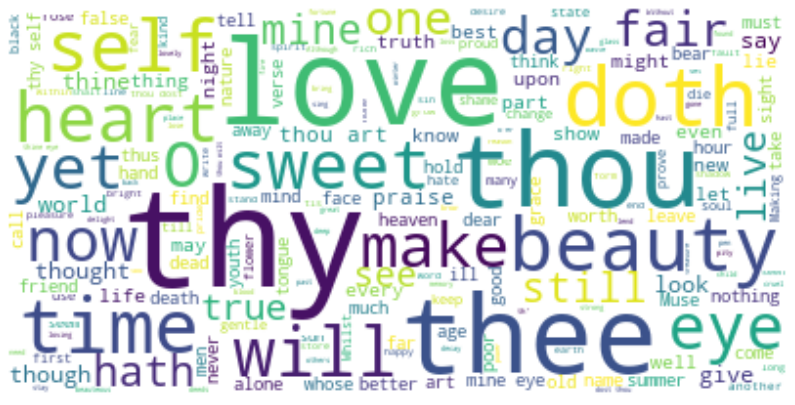

In [4]:
plt.rcParams['savefig.dpi'] = 300
plt.figure(figsize = (14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("poemcloud.png")
plt.show()

## Investigating the corpus

In [5]:
corpus = data.lower().split("\n")
corpus

['the sonnets',
 '',
 'by william shakespeare',
 '',
 'from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou contracted to thine own bright eyes,',
 "feed'st thy light's flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thy self thy foe, to thy sweet self too cruel:',
 "thou that art now the world's fresh ornament,",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content,',
 "and tender churl mak'st waste in niggarding:",
 'pity the world, or else this glutton be,',
 "to eat the world's due, by the grave and thee.",
 '',
 'when forty winters shall besiege thy brow,',
 "and dig deep trenches in thy beauty's field,",
 "thy youth's proud livery so gazed on now,",
 'will be a tattered weed of small worth held:  ',
 'then being asked, where all thy beauty lies,',
 'where all the treasure of thy lu

## Removing characters

In [6]:
type(corpus)
mycorpus = [re.compile(r"by william shakespeare").sub("", m) for m in corpus]
finalcorpus = [re.compile(r"the sonnets").sub("", m) for m in mycorpus]
finalcorpus

['',
 '',
 '',
 '',
 'from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou contracted to thine own bright eyes,',
 "feed'st thy light's flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thy self thy foe, to thy sweet self too cruel:',
 "thou that art now the world's fresh ornament,",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content,',
 "and tender churl mak'st waste in niggarding:",
 'pity the world, or else this glutton be,',
 "to eat the world's due, by the grave and thee.",
 '',
 'when forty winters shall besiege thy brow,',
 "and dig deep trenches in thy beauty's field,",
 "thy youth's proud livery so gazed on now,",
 'will be a tattered weed of small worth held:  ',
 'then being asked, where all thy beauty lies,',
 'where all the treasure of thy lusty days;',
 'to say within thine

In [7]:
length = []
for line in corpus:
    length.append(len(line))
pd.Series(length).describe()

count    2469.000000
mean       37.183880
std        14.648481
min         0.000000
25%        38.000000
50%        42.000000
75%        45.000000
max        59.000000
dtype: float64

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)

print(total_words)

3200


## Creating train and target

In [9]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

train, target = input_sequences[:,:-1],input_sequences[:,-1]
target = ku.to_categorical(target, num_classes=total_words+1)

In [10]:
model = Sequential()
model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           320100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3200)              323200    
_________________________________________________________________
dense_1 (Dense)              (None, 3201)              10246401  
Total params: 11,351,301
Trainable params: 11,351,301
Non-trainable params: 0
____________________________________________

In [11]:
history = model.fit(train, target, epochs=160, verbose=1)

Epoch 1/160
485/485 [==============================] - 36s 75ms/step - loss: 6.8584 - accuracy: 0.0209
Epoch 2/160
485/485 [==============================] - 37s 75ms/step - loss: 6.4873 - accuracy: 0.0216
Epoch 3/160
485/485 [==============================] - 36s 74ms/step - loss: 6.3926 - accuracy: 0.0228
Epoch 4/160
485/485 [==============================] - 35s 72ms/step - loss: 6.2713 - accuracy: 0.0309
Epoch 5/160
485/485 [==============================] - 34s 70ms/step - loss: 6.1711 - accuracy: 0.0374
Epoch 6/160
485/485 [==============================] - 35s 71ms/step - loss: 6.0889 - accuracy: 0.0392
Epoch 7/160
485/485 [==============================] - 33s 68ms/step - loss: 6.0084 - accuracy: 0.0404
Epoch 8/160
485/485 [==============================] - 33s 69ms/step - loss: 5.9322 - accuracy: 0.0434
Epoch 9/160
485/485 [==============================] - 33s 68ms/step - loss: 5.8471 - accuracy: 0.0518
Epoch 10/160
485/485 [==============================] - 33s 68ms/step - l

485/485 [==============================] - 33s 67ms/step - loss: 1.3029 - accuracy: 0.7704
Epoch 80/160
485/485 [==============================] - 33s 67ms/step - loss: 1.2915 - accuracy: 0.7724
Epoch 81/160
485/485 [==============================] - 33s 69ms/step - loss: 1.2726 - accuracy: 0.7769
Epoch 82/160
485/485 [==============================] - 33s 67ms/step - loss: 1.2569 - accuracy: 0.7775
Epoch 83/160
485/485 [==============================] - 33s 67ms/step - loss: 1.2431 - accuracy: 0.7822
Epoch 84/160
485/485 [==============================] - 33s 68ms/step - loss: 1.2325 - accuracy: 0.7853
Epoch 85/160
485/485 [==============================] - 34s 69ms/step - loss: 1.2167 - accuracy: 0.7866
Epoch 86/160
485/485 [==============================] - 33s 69ms/step - loss: 1.2143 - accuracy: 0.7850
Epoch 87/160
485/485 [==============================] - 33s 69ms/step - loss: 1.2088 - accuracy: 0.7875
Epoch 88/160
485/485 [==============================] - 33s 69ms/step - loss:

485/485 [==============================] - 31s 65ms/step - loss: 0.8587 - accuracy: 0.8295
Epoch 158/160
485/485 [==============================] - 31s 65ms/step - loss: 0.8511 - accuracy: 0.8317
Epoch 159/160
485/485 [==============================] - 31s 65ms/step - loss: 0.8361 - accuracy: 0.8330
Epoch 160/160
485/485 [==============================] - 32s 66ms/step - loss: 0.8360 - accuracy: 0.8338


## Plotting results

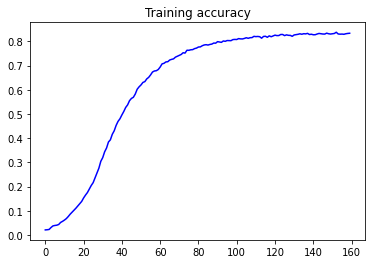

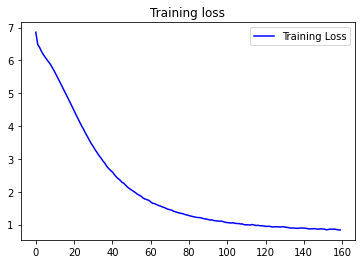

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# Attempting text generator

In [16]:
seed_text = "you are my unicorn, my night, my sun"
next_words = 150
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

you are my unicorn, my night, my sun decay decay place free still free go lips of worth me face will ill and decay decay dwell cold rare near heir prove sight torn torn rotten head near pen decays rotten near heir slain prove bad with told leaves die decays decays staineth expressed expressed gone made short thee shame out out old night is women's pleasure steel precious sun near heir go age lies hour shows bring bright true matter forth too near end who grow proceeds crowned with rased twain remain last better bad with loss cold near slain slain age may prove thee new bright might shine foes lie in strife thee am ' thine usest though abused thine praise mine praise praise thee mine praise mine own worth still well is too world's deeds with thy part report rare missed missed missed brought shame deemed rotten antique lusty hours lies twain still still die so
